# Análisis de Clustering sobre Condiciones Oceánicas y Severidad del Blanqueo de Corales

## Objetivo
Aplicar técnicas de aprendizaje no supervisado, específicamente **K-Means** y **DBSCAN**, para identificar patrones en variables climáticas oceánicas (como temperatura superficial, pH y biodiversidad), con el fin de explorar posibles agrupaciones naturales en los datos y su relación con eventos de blanqueo de corales.


Importar librerías necesarias.

In [1]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans, DBSCAN
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA
from sklearn.neighbors import NearestNeighbors

Cargar el dataset

In [2]:

df = pd.read_csv("realistic_ocean_climate_dataset.csv")
df.head()


,Date,Location,Latitude,Longitude,SST (°C),pH Level,Bleaching Severity,Species Observed,Marine Heatwave
0,2015-01-01,Red Sea,20.0248,38.4931,29.47,8.107,NaN,106,False
1,2015-01-07,Great Barrier Reef,-18.2988,147.7782,29.65,8.004,High,116,False
2,2015-01-14,Caribbean Sea,14.9768,-75.0233,28.86,7.947,High,90,False
3,2015-01-20,Great Barrier Reef,-18.3152,147.6486,28.97,7.995,Medium,94,False
4,2015-01-27,Galápagos,-0.8805,-90.9769,28.60,7.977,NaN,110,False


Convertir columnas necesarias

In [3]:

df["Marine Heatwave"] = df["Marine Heatwave"].astype(int)
df['Bleaching Severity'] = df['Bleaching Severity'].replace({np.nan: 'None'})


Selección de características para clustering

In [4]:

features = ["Latitude", "Longitude", "SST (°C)", "pH Level", "Species Observed", "Marine Heatwave"]
X = df[features]


Normalización de las variables

In [5]:

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)


Reducción de dimensionalidad para visualización

In [6]:

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)


Evaluación de KMeans para distintos valores de k

In [8]:
import os
os.environ["LOKY_MAX_CPU_COUNT"] = "4"

inertias = []
silhouettes = []
k_values = range(2, 10)

for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    labels = kmeans.fit_predict(X_scaled)
    inertias.append(kmeans.inertia_)
    silhouettes.append(silhouette_score(X_scaled, labels))


Visualización de los resultados del método del codo y silhouette

### **Método del Codo (Inercia)**

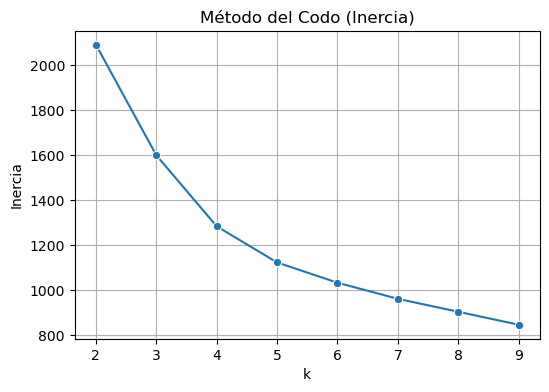

In [9]:

plt.figure(figsize=(6, 4))
sns.lineplot(x=k_values, y=inertias, marker='o')
plt.title("Método del Codo (Inercia)")
plt.xlabel("k")
plt.ylabel("Inercia")
plt.grid(True)
plt.show()


En el gráfico, el codo más notorio aparece alrededor de k = 3 o 4, donde la reducción de inercia empieza a ser mucho más lenta.
Sin embargo, la caída más abrupta se da de k=2 a k=3, y a partir de ahí el beneficio marginal se reduce.

Podemos suponer que un valor de k = 3 o k = 4 es un número óptimo de clusters.

### **Silhouette Score**

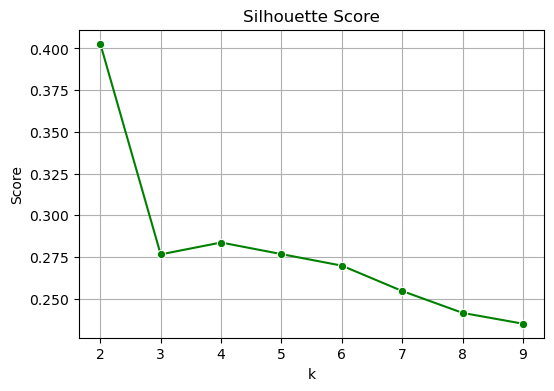

In [10]:

plt.figure(figsize=(6, 4))
sns.lineplot(x=k_values, y=silhouettes, marker='o', color='green')
plt.title("Silhouette Score")
plt.xlabel("k")
plt.ylabel("Score")
plt.grid(True)
plt.show()


El valor más alto se da en k = 2 (~0.40), lo que indica que con dos clusters, los datos están mejor separados y son más compactos.

A partir de k = 3, el silhouette score cae bruscamente, y aunque se estabiliza entre k = 3 y 5, no vuelve a superar los 0.29.

Esto implica que agregar más clusters puede estar forzando la partición sin una ganancia real en calidad.


A pesar de que el método del codo sugiere k = 3 o 4, el Silhouette Score indica que la mejor separación natural entre grupos se da con k = 2.

Sin embargo, como el objetivo del análisis requiere distinguir los tipos de blanqueo coralino, k = 4 es la opción seleccionada.

In [16]:

kmeans_4 = KMeans(n_clusters=4, random_state=42, n_init=10)
df["Cluster_k4"] = kmeans_4.fit_predict(X_scaled)


Identificamos los centroides.

In [17]:

centroids = kmeans_4.cluster_centers_
centroids_pca = pca.transform(centroids)


Visualizamos los puntos por cluster y los centroides en Espacio PCA.

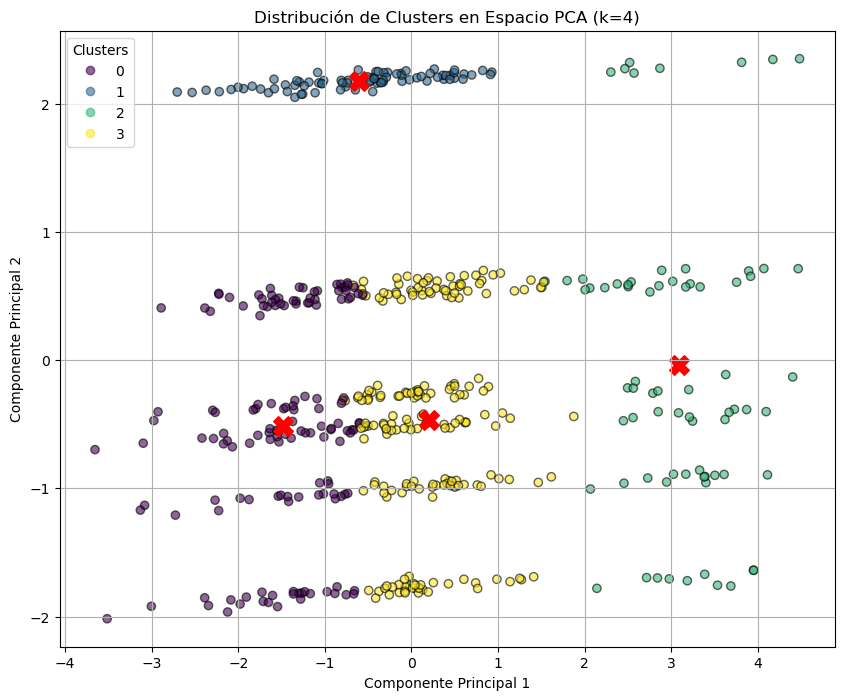

In [27]:
plt.figure(figsize=(10, 8))

scatter = plt.scatter(X_pca[:, 0], X_pca[:, 1], c=df['Cluster_k4'], cmap='viridis', alpha=0.6, edgecolor='k')

plt.scatter(centroids_pca[:, 0], centroids_pca[:, 1], marker='X', s=200, c='red', label='Centroides')

plt.legend(*scatter.legend_elements(), title='Clusters')
plt.title('Distribución de Clusters en Espacio PCA (k=4)')
plt.xlabel('Componente Principal 1')
plt.ylabel('Componente Principal 2')
plt.grid(True)

plt.show()

Analizamos las características de los centroides.


Características medias por cluster:
    Latitude   Longitude   SST (°C)  pH Level  Species Observed  \
0  12.516022  -10.985329  27.212041  8.092367        139.020408   
1 -18.284048  147.709199  28.209367  8.057354        125.468354   
2   8.805340    9.574981  30.845342  7.997562         97.630137   
3  11.572214  -23.820088  28.796915  8.034851        113.238806   

   Marine Heatwave  Cluster  
0    -2.775558e-16        0  
1    -2.775558e-17        1  
2     1.000000e+00        2  
3    -3.330669e-16        3  


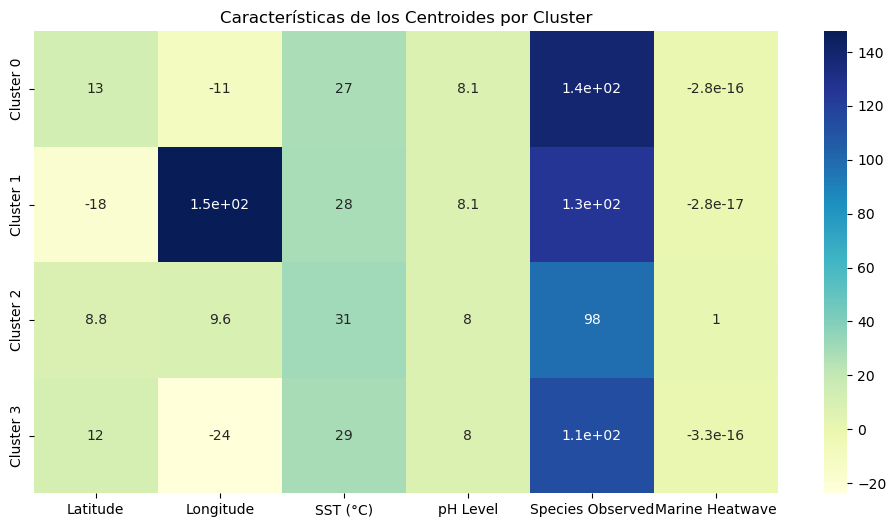

In [29]:

centroids_df = pd.DataFrame(scaler.inverse_transform(kmeans_4.cluster_centers_), 
                           columns=features)
centroids_df['Cluster'] = range(4)

print("\nCaracterísticas medias por cluster:")
print(centroids_df)

plt.figure(figsize=(12, 6))
sns.heatmap(centroids_df.drop('Cluster', axis=1), 
            annot=True, cmap='YlGnBu', 
            yticklabels=[f'Cluster {i}' for i in range(4)])
plt.title('Características de los Centroides por Cluster')
plt.show()

Validamos los valores obtenidos con los valores de severidad real.


Frecuencia absoluta por cluster:
Bleaching Severity  High  Low  Medium  None
Cluster_k4                                 
0                     23   36      42    46
1                     12   20      23    24
2                     15   22      20    16
3                     38   54      45    64


<Figure size 1000x600 with 0 Axes>

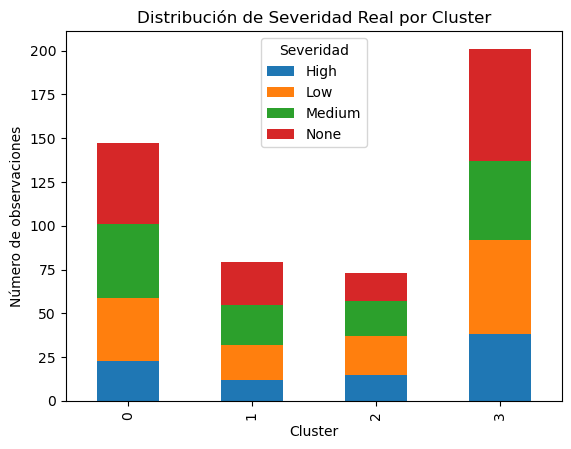

In [30]:

crosstab = pd.crosstab(df['Cluster_k4'], df['Bleaching Severity'])
    
print("\nFrecuencia absoluta por cluster:")
print(crosstab)

plt.figure(figsize=(10, 6))
crosstab.plot(kind='bar', stacked=True)
plt.title('Distribución de Severidad Real por Cluster')
plt.ylabel('Número de observaciones')
plt.xlabel('Cluster')
plt.legend(title='Severidad')
plt.show()


Generamos tablas de frecuencia y proporción por cluster

In [31]:

proportions = crosstab.div(crosstab.sum(axis=1), axis=0)
print("\nProporciones internas por cluster:")
print(proportions)



Proporciones internas por cluster:
Bleaching Severity      High       Low    Medium      None
Cluster_k4                                                
0                   0.156463  0.244898  0.285714  0.312925
1                   0.151899  0.253165  0.291139  0.303797
2                   0.205479  0.301370  0.273973  0.219178
3                   0.189055  0.268657  0.223881  0.318408


Y visualizamos los resultados en un gráfico de barras apiladas (por proporción):

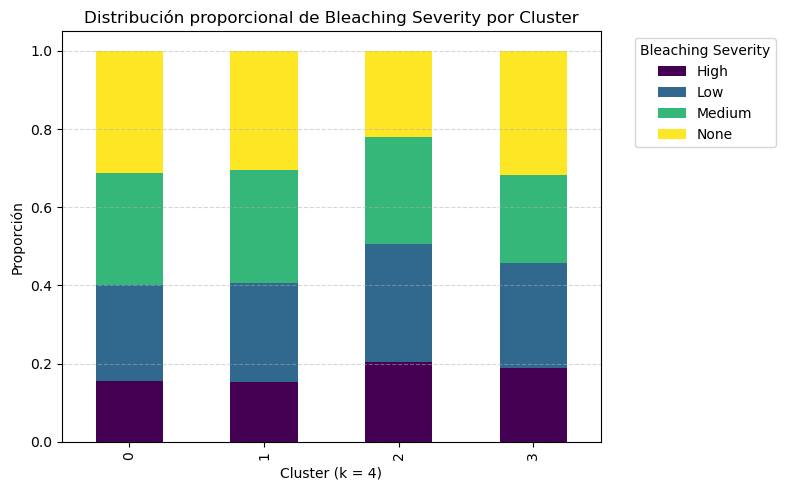

In [32]:

proportions.plot(kind="bar", stacked=True, figsize=(8, 5), colormap="viridis")

plt.title("Distribución proporcional de Bleaching Severity por Cluster")
plt.ylabel("Proporción")
plt.xlabel("Cluster (k = 4)")
plt.legend(title="Bleaching Severity", bbox_to_anchor=(1.05, 1), loc="upper left")
plt.tight_layout()
plt.grid(True, axis='y', linestyle='--', alpha=0.5)
plt.show()


Los clusters no son homogéneos, pero muestran patrones consistentes:
- Todos los clusters tienen las cuatro categorías de blanqueamiento, lo cual indica que no hay una separación perfecta.
- Sin embargo, las proporciones varían ligeramente entre clusters, lo que sugiere diferencias ambientales asociadas.

**Descripción de cada cluster**

**Cluster 0:**

SST: 27.2 °C, pH: 8.09, cantidad de especies observadas: 139, Marine Heatwave: 0.

Regiones relativamente estables, biodiversas y menos estresada térmicamente. Coincide con un alto % de observaciones con "None" en bleaching (31%) y la menor proporción de High bleaching (15.6%).

**Cluster 1:**

SST: 28.2 °C, pH: 8.06, cantidad de especies observadas: 125.5, Marine Heatwave: 0.

Son regiones algo más cálidas que el promedio, sin eventos extremos, biodiversidad media. Perfil similar al Cluster 0 pero con temperaturas ligeramente mayores y un menor número de especies. Bleaching con proporciones similares (30% sin blanqueamiento).

**Cluster 2:**

SST: 30.85 °C, pH: 7.997, cantidad de especies observadas: 97.6, Marine Heatwave: 1.

Regiones con altísimo estrés térmico y químico, baja biodiversidad y presencia confirmada de eventos extremos. Aunque sorprendentemente, tiene proporciones de bleaching "None" similares (22%), sus proporciones de High (20.5%) y Low (30.1%) son las más altas. Posiblemente una zona de transición o adaptabilidad, pero en riesgo.

**Cluster 3:**

SST: 28.8 °C, pH: 8.03, cantidad de especies observadas: 113, Marine Heatwave: 0

Regiones con condiciones cálidas y biodiversidad moderada. En cuanto a bleaching, tiene el mayor número absoluto de casos de High y None, con una proporción interna de bleaching "None" de 31.8%, la más alta. Es un cluster intermedio y numeroso, mixto en severidad.

**Conclusiones**

El clustering con k = 4 no segmenta perfectamente según los niveles de blanqueamiento, pero sí logra identificar grupos con perfiles ambientales distintos que muestran tendencias diferentes de severidad.

El Cluster 2 es el más ambientalmente comprometido: tiene la mayor temperatura, mayor acidez, menor biodiversidad y único con heatwaves.
Aunque no tiene la peor proporción de bleaching, representa un riesgo climático claro.

Los Clusters 0 y 1 parecen representar regiones estables: sin olas de calor, alta biodiversidad, menor severidad de bleaching.

El Cluster 3 es el más numeroso y heterogéneo: Tiene tanto muchos casos sin bleaching como muchos con severidad alta.

La reducción PCA explica ~68% de la varianza total, por lo que las visualizaciones son razonablemente representativas, pero no absolutas

Esto sugiere que variables como SST, pH y biodiversidad tienen influencia, aunque no determinan completamente la severidad del blanqueamiento. Puede haber factores adicionales en juego (corrientes, polución, tiempo de exposición, etc.).

### **DBSCAN en espacio reducido con PCA**

Antes de continuar con el análisis, es importante notar cuánta información retienen los componentes PCA y además entender qué variables contribuyen a cada componente, para esto análizamos lo siguiente:

In [14]:
print("Varianza explicada por PCA:", pca.explained_variance_ratio_)


Varianza explicada por PCA: [0.42480302 0.26010605]


Estos valores sugieren que PCA1 explica 42% de la varianza, y PCA2 26%, ahora vemos qué variables contribuyen a cada componente.

In [15]:
pca_components = pd.DataFrame(pca.components_, columns=features, index=['PCA1', 'PCA2'])
print(pca_components)

      Latitude  Longitude  SST (°C)  pH Level  Species Observed  \
PCA1  0.038808  -0.012592  0.573136 -0.420974         -0.490851   
PCA2 -0.704071   0.707076  0.050454  0.015212         -0.038113   

      Marine Heatwave  
PCA1         0.501694  
PCA2        -0.009955  


Es decir que PCA1 está mayormente influenciado por SST, el PH, las especies observadas y las olas de calor marina (refiere exclusivamente a factores climáticos) mientras que PCA2 incluye principalmente la ubicación de los datos.
El paso importante para utilizar DBSCAN es la elección del eps óptimo. Un eps demasiado pequeño clasificará todo como ruido, mientras que uno demasiado grande unirá todos los puntos en un solo cluster. Para esto podemos emplear una gráfica de distancia a los k-vecinos más cercanos (Elbow Method)

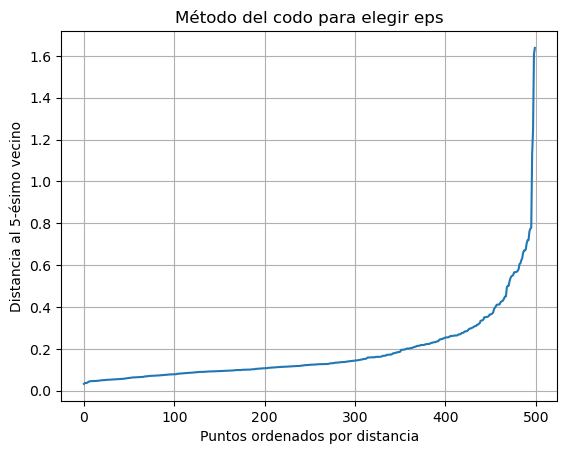

In [16]:
min_samples = 5
nbrs = NearestNeighbors(n_neighbors=min_samples).fit(X_pca)
distances, _ = nbrs.kneighbors(X_pca)
k_distances = np.sort(distances[:, -1])  # Distancias al k-ésimo vecino
plt.plot(k_distances)
plt.xlabel('Puntos ordenados por distancia')
plt.ylabel(f'Distancia al {min_samples}-ésimo vecino')
plt.title('Método del codo para elegir eps')
plt.grid(True)
plt.show()

El punto de inflexión indica que a partir de ese punto, las distancias a los vecinos aumentan abruptamente, señalando la densidad típica de los clusters. Probamos entonces con un valor cercano a 0.5. Es importante resaltar que probamos otros valores de min_samples y no había mucha variación en los resultados.

In [18]:
dbscan = DBSCAN(eps=0.5, min_samples=5)
dbscan_labels = dbscan.fit_predict(X_pca)

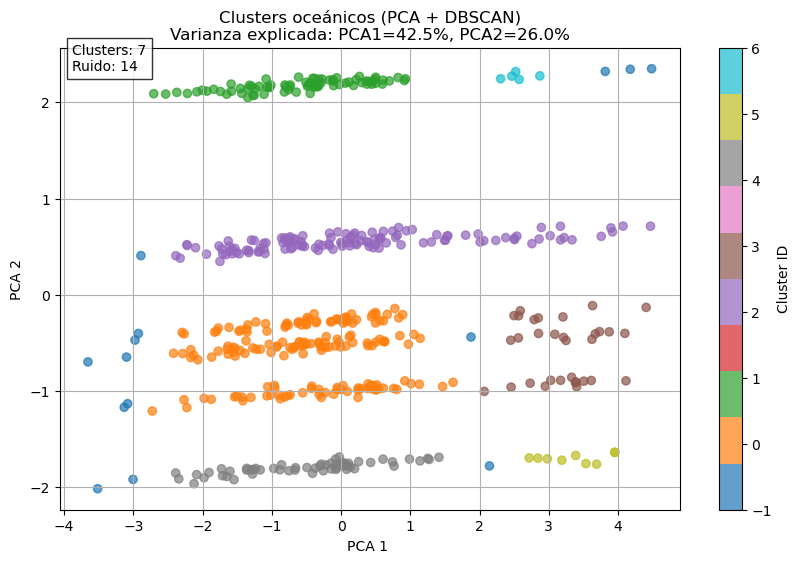

In [19]:
# Gráfico PCA con clusters
plt.figure(figsize=(10, 6))
scatter = plt.scatter(X_pca[:, 0], X_pca[:, 1], c=dbscan_labels, cmap='tab10', alpha=0.7)
plt.title("Clusters oceánicos (PCA + DBSCAN)\nVarianza explicada: PCA1={:.1%}, PCA2={:.1%}".format(
          pca.explained_variance_ratio_[0], pca.explained_variance_ratio_[1]))
plt.xlabel("PCA 1 ")
plt.ylabel("PCA 2")
plt.colorbar(scatter, label="Cluster ID")
plt.grid(True)

# Anotar estadísticas
n_clusters = len(set(dbscan_labels)) - (1 if -1 in dbscan_labels else 0)
plt.text(0.02, 0.95, f"Clusters: {n_clusters}\nRuido: {sum(dbscan_labels == -1)}",
         transform=plt.gca().transAxes, bbox=dict(facecolor='white', alpha=0.8))
plt.show()

Las conclusiones del gráfico son las siguientes:

Tenemos 7 clusters: El algoritmo encontró 7 grupos naturales en los datos (zonas con propiedades similares en temperatura, pH, ubicación, etc.).

Tenemos 14 puntos de ruido: que son mediciones atípicas que no encajan en ningún grupo (ej: transiciones entre zonas, errores de medición, o eventos extremos).

Podemos hacer un análisis estadístico de los clusters para ver qué representan

In [20]:
df["Cluster_DBSCAN"] = dbscan_labels  # Añade las etiquetas al DataFrame

# Tabla cruzada entre clusters y severidad de blanqueamiento
contingency_dbscan = pd.crosstab(df["Cluster_DBSCAN"], df["Bleaching Severity"])
print("Frecuencia absoluta por cluster (DBSCAN):")
print(contingency_dbscan)

Frecuencia absoluta por cluster (DBSCAN):
Bleaching Severity  High  Low  Medium  None
Cluster_DBSCAN                             
-1                     3    6       2     3
 0                    35   41      39    64
 1                    12   20      23    24
 2                    15   38      39    31
 3                     7    5      10    10
 4                    12   16      15    16
 5                     3    3       2     1
 6                     1    3       0     1


Para entender el riesgo relativo, normalizamos las filas y graficamos

Bleaching Severity  High   Low  Medium  None
Cluster_DBSCAN                              
-1                  0.21  0.43    0.14  0.21
 0                  0.20  0.23    0.22  0.36
 1                  0.15  0.25    0.29  0.30
 2                  0.12  0.31    0.32  0.25
 3                  0.22  0.16    0.31  0.31
 4                  0.20  0.27    0.25  0.27
 5                  0.33  0.33    0.22  0.11
 6                  0.20  0.60    0.00  0.20


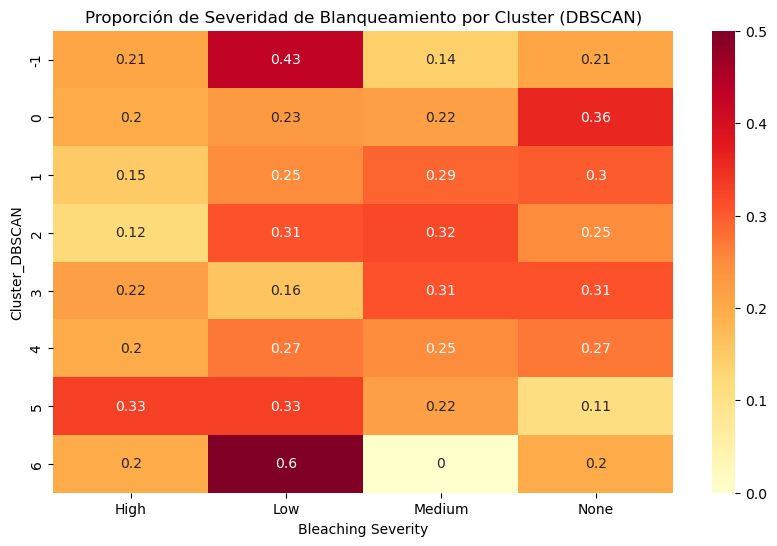

In [21]:
proportions_dbscan = contingency_dbscan.div(contingency_dbscan.sum(axis=1), axis=0).round(2)
print(proportions_dbscan)
plt.figure(figsize=(10, 6))
sns.heatmap(proportions_dbscan, annot=True, cmap="YlOrRd", vmin=0, vmax=0.5)
plt.title("Proporción de Severidad de Blanqueamiento por Cluster (DBSCAN)")
plt.show()

Acá es importante buscar qué cluster tiene alta la columna 'High' En este caso sería el 5, entonces procedemos a analizarlo en particular:

In [22]:
#Filtramos solo los datos del Cluster 5 para el análisis
cluster_5 = df[df["Cluster_DBSCAN"] == 5]

# Calculamos promedios de variables clave
print(cluster_5[["SST (°C)", "pH Level", "Marine Heatwave", "Latitude", "Longitude"]].mean())

SST (°C)            30.782222
pH Level             7.974889
Marine Heatwave      1.000000
Latitude            19.903178
Longitude         -155.569889
dtype: float64


Como vemos, con SST alta (>30°C) y pH relativamente bajo tenemos una alta correlación con blanqueamiento, por lo tanto, sumado a que Marine Heatwave = 1 (lo cual confirma que hay eventos de estrés térmico) vemos que este cluster es crucial para el análisis. Nos indica que en particular, en las zonas ubicadas a la latitud y longitud mencionadas (el área coincide con arrecifes costeros de Hawái, expuestos a estrés térmico y actividad humana) hay problemas ambientales.
Posibles causas: Combinación de temperaturas extremas, acidificación, o eventos de calor.
En este caso, el pH no influye tanto como sí las olas de calor extremas. Sería interesante investigar variables ambientales específicas y su ubicación geográfica para diseñar estrategias de conservación.